### 1. Importações

In [182]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [183]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [184]:
df_channels = pd.read_csv(r'C:\Users\Usuario\Documents\TREINAMENTO\PJ_treinamento3_24.0\Previsao-main\Previsao-main\channels.csv')
df_deliveries = pd.read_csv(r'C:\Users\Usuario\Documents\TREINAMENTO\PJ_treinamento3_24.0\Previsao-main\Previsao-main\deliveries.csv')
df_drivers = pd.read_csv(r'C:\Users\Usuario\Documents\TREINAMENTO\PJ_treinamento3_24.0\Previsao-main\Previsao-main\drivers.csv')
df_hubs = pd.read_csv(r'C:\Users\Usuario\Documents\TREINAMENTO\PJ_treinamento3_24.0\Previsao-main\Previsao-main\hubs.csv')
df_orders = pd.read_csv(r'C:\Users\Usuario\Documents\TREINAMENTO\PJ_treinamento3_24.0\Previsao-main\Previsao-main\orders.csv')
df_payments = pd.read_csv(r'C:\Users\Usuario\Documents\TREINAMENTO\PJ_treinamento3_24.0\Previsao-main\Previsao-main\payments.csv')
df_stores = pd.read_csv(r'C:\Users\Usuario\Documents\TREINAMENTO\PJ_treinamento3_24.0\Previsao-main\Previsao-main\stores.csv')

### 2. Unindo as bases

In [185]:
dfmerge1 = pd.merge(df_deliveries, df_drivers, on='driver_id')
dfmerge2 = pd.merge(df_stores, df_hubs, on='hub_id')
df = pd.merge(pd.merge(pd.merge(pd.merge(df_orders, df_channels, on='channel_id'), dfmerge1, on='delivery_order_id'), dfmerge2, on='store_id'), df_payments, on='payment_order_id')

### 3. Limpeza dos dados

#### 3.1. Dropando colunas que não influenciam na análise

In [186]:
df = df.drop(['store_id', 'channel_id', 'payment_order_id', 'delivery_order_id', 'delivery_id', 'driver_id','hub_id','payment_id'], axis=1)

df.columns

Index(['order_id', 'order_status', 'order_amount', 'order_delivery_fee',
       'order_delivery_cost', 'order_created_hour', 'order_created_minute',
       'order_created_day', 'order_created_month', 'order_moment_created',
       'order_moment_accepted', 'order_moment_ready', 'order_moment_collected',
       'order_moment_in_expedition', 'order_moment_delivering',
       'order_moment_delivered', 'order_moment_finished',
       'order_metric_collected_time', 'order_metric_paused_time',
       'order_metric_production_time', 'order_metric_walking_time',
       'order_metric_expediton_speed_time', 'order_metric_transit_time',
       'order_metric_cycle_time', 'channel_type', 'delivery_distance_meters',
       'delivery_status', 'driver_modal', 'driver_type', 'store_segment',
       'store_plan_price', 'store_latitude', 'store_longitude', 'hub_city',
       'hub_latitude', 'hub_longitude', 'payment_amount', 'payment_fee',
       'payment_method', 'payment_status'],
      dtype='object')

In [187]:
df.shape

(287459, 40)

In [188]:
df['payment_status'].value_counts()

payment_status
PAID          287111
CHARGEBACK       335
AWAITING          13
Name: count, dtype: int64

In [189]:
df['order_status'].value_counts()

order_status
FINISHED    287457
CANCELED         2
Name: count, dtype: int64

In [190]:
df['delivery_status'].value_counts()

delivery_status
DELIVERED     287343
DELIVERING       116
Name: count, dtype: int64

In [191]:
df = df[~df['payment_status'].isin(['CHARGEBACK', 'AWAITING'])]
df = df[~df['order_status'].isin(['CANCELED'])]
df = df[~df['delivery_status'].isin(['DELIVERING'])]

In [192]:
df = df.drop(['payment_status', 'order_status', 'delivery_status'], axis=1)

#### 3.2. Valores nulos

In [193]:
df.isnull().sum()

order_id                                  0
order_amount                              0
order_delivery_fee                        0
order_delivery_cost                    2636
order_created_hour                        0
order_created_minute                      0
order_created_day                         0
order_created_month                       0
order_moment_created                      0
order_moment_accepted                   510
order_moment_ready                     7956
order_moment_collected                17744
order_moment_in_expedition            37754
order_moment_delivering                2338
order_moment_delivered               271199
order_moment_finished                     2
order_metric_collected_time           24682
order_metric_paused_time              39187
order_metric_production_time           7958
order_metric_walking_time             43171
order_metric_expediton_speed_time     10032
order_metric_transit_time              2493
order_metric_cycle_time         

### 4. Análise do tempo de preparo

In [194]:
colunas = ['order_metric_production_time', 'order_metric_paused_time', 'order_created_hour', 'order_created_minute', 'order_moment_created', 'order_amount', 'payment_amount', 'channel_type']

In [212]:
df_preparo = df[['order_metric_production_time', 'order_metric_paused_time', 'order_created_hour', 'order_created_minute', 'order_moment_created', 'order_amount', 'payment_amount', 'channel_type']]

#### 4.1. Tempo circular

In [213]:
# Calculando a representação circular para as horas
df_preparo['hour_angle'] = (df_preparo['order_created_hour'] % 12) * 30 + (df_preparo['order_created_minute'] / 60) * 30
# Normalizando os ângulos para o intervalo [0, 360)
df_preparo['hour_angle'] = df_preparo['hour_angle'] % 360
df_preparo['radians'] = np.radians(df_preparo['hour_angle'])

# Visualizando o resultado
print(df_preparo[['order_created_hour', 'order_created_minute', 'hour_angle','radians']])

        order_created_hour  order_created_minute  hour_angle   radians
0                       15                    49       114.5  1.998402
1                       21                    19       279.5  4.878195
2                       20                    49       264.5  4.616396
3                       22                    35       317.5  5.541420
4                       16                    22       131.0  2.286381
...                    ...                   ...         ...       ...
287454                  22                    38       319.0  5.567600
287455                  17                     4       152.0  2.652900
287456                  16                    46       143.0  2.495821
287457                  16                    35       137.5  2.399828
287458                   0                     5         2.5  0.043633

[286995 rows x 4 columns]


C:\Users\Usuario\AppData\Local\Temp\ipykernel_2288\4063297737.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preparo['hour_angle'] = (df_preparo['order_created_hour'] % 12) * 30 + (df_preparo['order_created_minute'] / 60) * 30
C:\Users\Usuario\AppData\Local\Temp\ipykernel_2288\4063297737.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preparo['hour_angle'] = df_preparo['hour_angle'] % 360
C:\Users\Usuario\AppData\Local\Temp\ipykernel_2288\4063297737.py:5: SettingWithCopyWarning: 
A value is t

##### Finais de semana

In [197]:
from datetime import datetime

data_string = df_preparo['order_moment_created'].tolist()
final_de_semana = []
for data in data_string:
    data_hora = datetime.strptime(data, '%m/%d/%Y %I:%M:%S %p')
    if data_hora.weekday() >= 5:
        final_de_semana.append(data)

##### 4.1. TARGET

In [198]:
df_preparo['order_metric_production_time'].shape

(286995,)

Arriscado substituir os valores NaN na coluna order_metric_production_time por 0, porque não se tem informações suficientes e isso pode gerar uma previsibilidade errada. Além disso, são poucas colunas com NaN em relação ao total de linhas da base. Nesse caso, dropar as linhas com valores vazios.

In [199]:
df_preparo = df.dropna(subset=['order_metric_production_time'])

In [200]:
df_preparo['order_metric_production_time'].shape

(279037,)

##### 4.1.1. Outliers

In [216]:
df_preparo[['order_metric_production_time', 'order_metric_paused_time', 'hour_angle','radians', 'order_amount', 'payment_amount', 'channel_type']].describe()

,order_metric_production_time,order_metric_paused_time,hour_angle,radians,order_amount,payment_amount
count,279037.000000,247808.000000,286995.000000,286995.000000,286995.000000,286995.000000
mean,38.971975,8.949094,191.832598,3.348110,95.127403,93.255902
std,226.329792,76.446610,108.484119,1.893405,150.797962,151.717002
min,0.000000,-1082.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,1.000000,100.000000,1.745329,39.000000,32.900000
50%,15.000000,2.000000,176.000000,3.071779,68.000000,66.790000
75%,22.000000,5.000000,303.500000,5.297074,117.000000,121.800000
max,29544.000000,11712.000000,359.500000,6.274459,25000.000000,25000.000000


In [218]:
def calcula_outliers(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    diff = q3 - q1
    lim_inf = q1 - 1.5 * diff
    lim_sup = q3 + 1.5 * diff
    outliers = column[(column < lim_inf) | (column > lim_sup)] # Definição de outliers pelos percentis e limites
    return outliers, lim_inf, lim_sup

# Função para contar outliers e calcular a porcentagem
def conta_outliers(df):
    outlier_info = pd.DataFrame(columns=['Coluna', 'Outliers', 'Porcentagem', 'lim_inf', 'lim_sup']) # Criando um novo DataFrame
    for col in df.select_dtypes(include=['int', 'float']): # Loop para verificar cada coluna numérica
        outliers, lim_inf, lim_sup = calcula_outliers(df[col]) # Chamando a função para calcular outliers
        outlier_count = len(outliers) # Verificando o tamanho da lista
        percentage = (outlier_count / len(df)) * 100 # Porcentagem de outliers
        outlier_info.loc[len(outlier_info)] = [col, outlier_count, percentage, lim_inf, lim_sup] # Atribuindo valores usando .loc[]
    return outlier_info # Retornando DataFrame

outlier_df = conta_outliers(df_preparo)
print(outlier_df)

                         Coluna  Outliers  Porcentagem     lim_inf     lim_sup
0  order_metric_production_time     14016     4.883709  -10.500000   41.500000
1      order_metric_paused_time     25398     8.849632   -5.000000   11.000000
2            order_created_hour     25509     8.888308    4.500000   32.500000
3          order_created_minute         0     0.000000  -31.000000   89.000000
4                  order_amount     14748     5.138765  -78.000000  234.000000
5                payment_amount     12544     4.370808 -100.450000  255.150000
6                    hour_angle         0     0.000000 -205.250000  608.750000
7                       radians         0     0.000000   -3.582288   10.624692


##### 4.2. Numéricas - Matriz de Correlação

In [202]:
df_preparo['order_metric_paused_time'].fillna(0, inplace=True)
df_preparo['order_metric_collected_time'].fillna(0, inplace=True)
df_preparo['order_amount'].fillna(0, inplace=True)
df_preparo['payment_amount'].fillna(0, inplace=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_2288\1624361633.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_preparo['order_metric_paused_time'].fillna(0, inplace=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_2288\1624361633.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preparo['order_metric_paused_time'].fillna(0, inpla

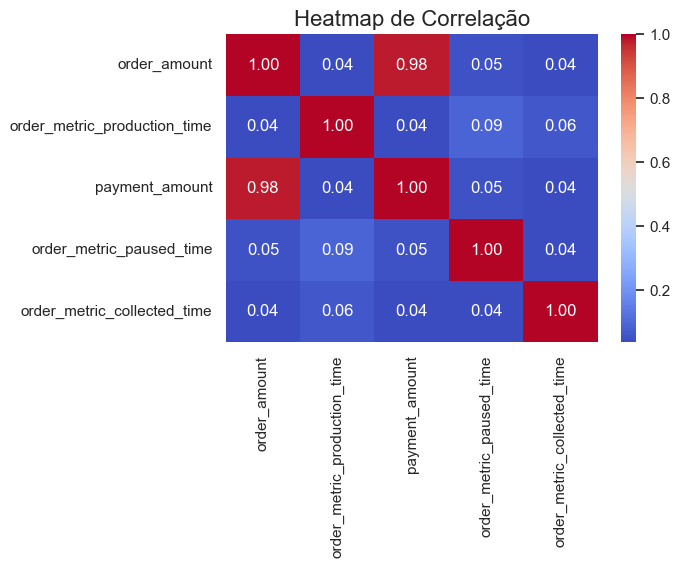

In [203]:
sns.set(style="white")
plt.figure(figsize=(6, 4))
heatmap = sns.heatmap(df_preparo[['order_amount', 'order_metric_production_time', 'payment_amount', 'order_metric_paused_time', 'order_metric_collected_time']].corr(), annot=True, cmap="coolwarm", fmt=".2f")
heatmap.set_title('Heatmap de Correlação', fontsize=16)
plt.show()

##### 4.3. Categórica - ANOVA

In [204]:
df_preparo['channel_type'].value_counts()

channel_type
MARKETPLACE    254156
OWN CHANNEL     24881
Name: count, dtype: int64

In [205]:
from scipy.stats import f_oneway

# Suponha que 'categoria' é a coluna categórica e 'numerico' é a coluna numérica
MARKETPLACE = df_preparo[df_preparo['channel_type'] == 'MARKETPLACE']['order_metric_production_time']
OWNCHANNEL = df_preparo[df_preparo['channel_type'] == 'OWN CHANNEL']['order_metric_production_time']

# Executar ANOVA
stat, p_valor = f_oneway(MARKETPLACE, OWNCHANNEL)

# Interpretar o resultado
if p_valor < 0.05:
    print("Há evidências suficientes para rejeitar a hipótese nula. A coluna categórica influencia a coluna numérica.")
else:
    print("Não há evidências suficientes para rejeitar a hipótese nula. A coluna categórica não influencia a coluna numérica.")

Há evidências suficientes para rejeitar a hipótese nula. A coluna categórica influencia a coluna numérica.


### 5. Análise do tempo de expedição

In [206]:
colunas = ['order_metric_walking_time', 'order_metric_expediton_speed_time', 'driver_modal']

### 6. Análise do tempo de trânsito

In [207]:
colunas = ['order_metric_transit_time', 'order_delivery_fee', 'delivery_distance_meters', 'hub_city', 'driver_modal', 'driver_type']

- Usar um objeto datatime para verificar se o horário da entrega ('order_moment_delivering') é um horário de pico

verificar se existe uma associação significativa entre duas variáveis categóricas

In [208]:
# Crie uma tabela de contingência usando pd.crosstab() para as duas variáveis categóricas
tabela_contingencia = pd.crosstab(df['variavel1'], df['variavel2'])

# Aplique o teste de Qui-Quadrado
chi2, p_valor, _, _ = chi2_contingency(tabela_contingencia)

# Exibe os resultados
print("Estatística Qui-Quadrado:", chi2)
print("Valor-p:", p_valor)

KeyError: 'variavel1'